In [24]:
import pandas as pd
import numpy as np
import loc_utils as lut
import tarfile
from shutil import rmtree, copyfileobj
from glob import glob
from os import path, mkdir
import re

    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Join raw invidividual csvs

In [16]:
def join_zipped_csvs(loc, filename):
    # Extract compressed files in a temp directory with same name
    temp_dir = path.join(loc, filename.split('.')[0])
    if not path.exists(temp_dir):
        mkdir(temp_dir)
    with tarfile.open(path.join(loc, filename), 'r') as file:
        file.extractall(temp_dir)
        
    # Import csv files from folder
    all_files = glob(temp_dir + '/results/*.csv')
    all_files.sort()  # glob lacks reliable ordering, so impose your own if output order matters
    with open(path.join(loc, filename.split('.')[0]+'.csv'), 'wb') as outfile:
        for i, fname in enumerate(all_files):
            with open(fname, 'rb') as infile:
                if i != 0:
                    # Throw away header on all but the first file
                    infile.readline()
                # Block copy rest of file from input to output without parsing
                copyfileobj(infile, outfile)
    
    # Remove temp dir
    rmtree(temp_dir)


for filename in ['results10x1000.tar.gz']:
    join_zipped_csvs(
        loc = '../data/plafrim', 
        filename = filename
    )

# Select the min AIC model per model form in each subject

In [17]:
def get_best_per_sid_and_form(csv_paths, index_data_path, save_path, include_groups=[], exclude_vars=[]):
    # Get data
    df = pd.concat([pd.read_csv(csv_path) for csv_path in csv_paths], axis=0)
    
    # Get best model per form per subject
    df = df.sort_values(by=['sid', 'form', 'aic']).groupby(['sid', 'form']).head(1)
    
    # Berge with group data
    groups_df = pd.read_csv(index_data_path).filter(items=['sid','group']).groupby('sid').head(1)
    df = pd.merge(df, groups_df, on='sid', how='left')
    
    if exclude_vars:
        for i in exclude_vars:
            df = df[~df.form.str.contains(i)]
        df = df.drop(columns=exclude_vars)
    print(f'Excluded {exclude_vars}.\nLongest full model is: {sorted(list(df.form.unique()), key=len)[-1]}')
    
    if include_groups:
        include = np.any(pd.concat([df.group==g for g in include_groups], axis=1), axis=1)
        df = df.loc[include, :]
        
    display(df.head())
    
    # Save data
    if save_path:
        print(f'Saving to {save_path}')
        df.to_csv(save_path, index=False)

    
get_best_per_sid_and_form(
    csv_paths = ['../data/plafrim/results10x1000.csv'],
    index_data_path = '../data/combined_main.csv',
    save_path = '../data/best_per_form_app4.csv',
    include_groups = [0], 
    exclude_vars = ['diff', 'delta_diff']
)

Excluded ['diff', 'delta_diff'].
Longest full model is: mean + var + delta_mean + delta_var


,sid,form,aic,tau,step,scale,mean,var,delta_mean,delta_var,group
1,0,delta_mean,701.1472,255.343829,0.892194,0.001332,NaN,NaN,-0.365179,NaN,0
3,0,delta_mean + delta_var,703.1472,633.691913,0.978054,0.514506,NaN,NaN,0.167900,-0.186032,0
9,0,delta_var,701.1472,150.868043,0.925033,0.008804,NaN,NaN,NaN,-0.953222,0
15,0,mean,699.1472,382.533218,0.980051,NaN,-0.000409,NaN,NaN,NaN,0
17,0,mean + delta_mean,486.8968,927.729437,0.877321,0.001855,-0.001969,NaN,-0.097522,NaN,0


Saving to ../data/best_per_form_app4.csv


# Compute AIC stats

In [21]:
def aic_stats(data_path, aicc=True, save_path=''):
    # Open dataset
    df = pd.read_csv(data_path)
    
    # Get number of vars per model
    K = len(df.loc[:, 'tau':].columns)
    df['k'] = K - df.loc[:, 'tau':].isnull().sum(axis=1)
    
    # Conver AIC to AICc
    if aicc:
        df['aicc'] = df.aic + (2*df.k**2 + 2*df.k)/(250-df.k-1)    
        col = 'aicc'
    else:
        col = 'aic'
        
    # Compute delta AIC or AICc and sort models within subjects
    delta_col = f'delta_{col}'
    df[delta_col] = df.groupby('sid')[col].transform(lut.delta_aic)
    df = df.sort_values(by=['sid', delta_col])
    
    # Compute Akaike weights
    df['akw'] = df.groupby('sid')[delta_col].transform(lut.akaike_w)
    
    # Evidence ratio and ranks
    df['er'] = df.groupby('sid')['akw'].transform(lut.evidence_ratio)
    
    # Ranks 
    df['drank'] = df.groupby('sid')[delta_col].transform('rank').astype(int) - 1
    
    display(df.head())
    print(df.columns)
    
    # Save data
    if save_path:
        print(f'Saving to {save_path}')
        df.to_csv(save_path, index=False)
        
        
aic_stats(
    data_path = '../data/best_per_form_app4.csv',
    save_path = '../data/aic_stats_app4.csv'
)

,sid,form,aic,tau,step,scale,mean,var,delta_mean,delta_var,group,k,aicc,delta_aicc,akw,er,drank
13,0,var + delta_mean + delta_var,200.9594,400.748590,0.983901,0.013794,NaN,1.000000,0.160092,-0.998801,0,7,201.422210,0.000000,1.000000e+00,1.000000e+00,0
10,0,mean + var + delta_var,437.3286,1000.000000,0.860970,0.003762,-0.001691,-0.938066,NaN,-1.000000,0,7,437.791410,236.369200,4.710645e-52,2.122852e+51,1
4,0,mean + delta_mean,486.8968,927.729437,0.877321,0.001855,-0.001969,NaN,-0.097522,NaN,0,6,487.242479,285.820269,8.608295e-63,1.161670e+62,2
5,0,mean + delta_mean + delta_var,490.2942,759.460109,0.985216,0.009855,0.000655,NaN,0.111273,-0.897958,0,7,490.757010,289.334800,1.485068e-63,6.733696e+62,3
8,0,mean + var + delta_mean,494.9430,456.377048,0.962275,0.000383,-0.003974,0.852254,-0.840987,NaN,0,7,495.405810,293.983600,1.453023e-64,6.882205e+63,4


Index(['sid', 'form', 'aic', 'tau', 'step', 'scale', 'mean', 'var',
       'delta_mean', 'delta_var', 'group', 'k', 'aicc', 'delta_aicc', 'akw',
       'er', 'drank'],
      dtype='object')
Saving to ../data/aic_stats_app4.csv


# Behavioral descriptors

In [25]:
def make_behavior_dataset(input_data_path, save_path=''):
    # Read clean data and drop unused data
    df = pd.read_csv(input_data_path, index_col=None).set_index(['sid','activity'])
    df = df.loc[:, 'group,stage,trial,correct'.split(',')]
    df = df.loc[df.trial <= 60+250]
    df = df.loc[df.group != 2, :]
    df['score'] = df.correct.astype(int).replace(0, -1)
    df = df.sort_index()
    cols = ['sid','group','activity','n','nfree','alloc','ipc15','fpc15','pcall','fscore','maxscore','speed','hirun']
    outdict = dict(zip(cols, [[] for col in cols]))
    for i, sdf in df.groupby('sid'):
        for a in ['A1', 'A2', 'A3', 'A4']:
            outdict['sid'].append(i)
            outdict['group'].append(sdf.group.values[0])
            outdict['activity'].append(a)
            
            x = sdf.loc[(i, a), 'correct'].values.astype(int)
            y = sdf.loc[(i, a), 'score'].values.astype(int)
            
            outdict['n'].append(x.size)
            outdict['nfree'].append(x.size-15)
            outdict['alloc'].append((x.size-15)/250)
            outdict['ipc15'].append(x[:15].mean()) # initial window pc
            outdict['fpc15'].append(x[-15:].mean()) # final window pc
            outdict['pcall'].append(x.mean()) # final overall pc
            outdict['fscore'].append(max([y.sum(), 0]))
            outdict['maxscore'].append(max([np.cumsum(y).max(), 0]))
            outdict['speed'].append(max([np.cumsum(y).max(), 0])/(np.cumsum(y).argmax()+1))
            outdict['hirun'].append(len(max(re.sub(' +', '%', ''.join(x.astype(str)).replace('0',' ')).split('%'))))
            
    df = pd.DataFrame(outdict)
    display(df.speed.min())
    # Save data
    if save_path:
        print('saving to {}'.format(path.abspath(save_path)))
        df.to_csv(save_path, index=False)
    
    
make_behavior_dataset(
    input_data_path = '../data/clean_data.csv',
#     save_path = '../data/behavior_data.csv'
)

0.0

# MISC

activity,A1,A2,A3,A4
sid,,,,
0,0.000,0.064,0.712,0.224
1,0.296,0.116,0.388,0.200
2,0.472,0.132,0.000,0.396
3,0.180,0.076,0.336,0.408
4,0.504,0.016,0.320,0.160


PC1:
A1 [∆aic(L,Q)=-1.67)]: 0.947, 0.332  
A2 [∆aic(L,Q)=0.16)]: 3.265, 0.041  *
A3 [∆aic(L,Q)=-1.41)]: 1.083, 0.300  
A4 [∆aic(L,Q)=0.21)]: 3.876, 0.023  *
A3vsA4 [∆aic(L,Q)=-1.56)]: 1.358, 0.246  
PC2:
A1 [∆aic(L,Q)=-1.91)]: 7.200, 0.008  **
A2 [∆aic(L,Q)=-0.47)]: 0.097, 0.756  
A3 [∆aic(L,Q)=-1.06)]: 4.294, 0.040  *
A4 [∆aic(L,Q)=-1.39)]: 3.207, 0.075  
A3vsA4 [∆aic(L,Q)=-2.00)]: 0.007, 0.935  


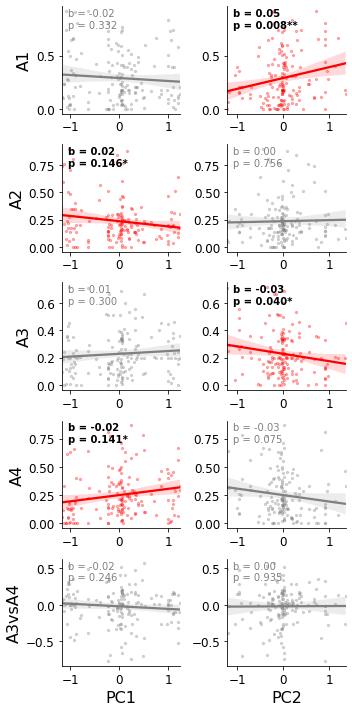

In [154]:
def behavioral_correlations_choices(data_path, behavior_data_path):
    df = pd.read_csv(behavior_data_path).filter(items=['sid','activity','alloc'])
    df = df.pivot(index='sid', columns='activity', values='alloc')
    display(df.head())
    
    df['A3vsA4'] = df.A3 - df.A4
    rows = list(df.columns)
    cols = ['PC1', 'PC2']#, 'PC3']
    df = pd.read_csv(data_path).merge(df, on='sid')
    
    fig, ax = plt.subplots(ncols=len(cols), nrows=len(rows), num='behavior', figsize=[2.5*len(cols), 2*len(rows)])
    for j, col in enumerate(cols):
        df[f'z{col}'] = stats.zscore(df.loc[:, col])
        print(f'{col.upper()}:')
        for i, row in enumerate(rows):
            reg = ols(f'{row} ~ z{col}', data=df).fit()
            qreg = ols(f'{row} ~ z{col} + np.power(z{col}, 2)', data=df).fit()
            aic_diff = reg.aic - qreg.aic
            model = [reg, qreg][np.argmin([reg.aic, qreg.aic])]
            
            f, fpval = model.fvalue, model.f_pvalue
#             slope, intercept, r_value, p_value, std_err = stats.linregress(df.loc[:, col], df.loc[:, row])
            sign = '*' if fpval < .05 else ''
            sign = '**' if fpval < .01 else sign
            print(f'{row} [∆aic(L,Q)={aic_diff:.2f})]: {f:.3f}, {fpval:.3f}  {sign}')
            b2, pval = model.params.values[-1], model.pvalues.values[-1]
            report = f'b = {b2:.2f}\np = {pval:.3f}{sign}'
            ax[i, j].text(.05, .98, report, va='top', ha='left', 
                          transform=ax[i, j].transAxes, fontweight='bold' if sign else 'regular', 
                          color='black' if sign else 'gray')
            
            sns.regplot(y=row, x=col, data=df, ax=ax[i, j], color='red' if sign else 'gray', scatter_kws={'s':5, 'alpha':.3}, order=2 if aic_diff>2 else 1)
            if j:
                ax[i,j].set_ylabel('')
            if i<len(rows)-1:
                ax[i,j].set_xlabel('')
    fig.tight_layout()
    fig.savefig(fname='../figures/correlations.png', dpi=300)

behavioral_correlations_choices(
    '../data/pca_data_unstand.csv',
    '../data/behavior_data.csv' 
)

,sid,form,aic,tau,alpha,scale,mean,var,delta_mean,delta_var,...,delta_aicc,akw,er,drank,n1,alphaC,n2,logn1,logn2,ndiff
13,0,var + delta_mean + delta_var,200.9594,400.748590,0.983901,0.013794,NaN,1.0,0.160092,-0.998801,...,0.0,1.000000,1.0,0,1.016363,0.013572,73.679192,0.007049,1.867345,1.861312
19,1,mean + delta_mean,606.2790,971.089611,0.253144,0.072381,-0.001946,NaN,0.011734,NaN,...,0.0,0.742416,1.0,0,3.950314,0.018323,54.576394,0.596632,1.737005,1.704374
35,2,mean + delta_mean + delta_var,265.7898,1000.000000,0.003777,0.001495,0.243067,NaN,-0.089648,-1.000000,...,0.0,0.602489,1.0,0,264.734901,0.000006,177061.035357,2.422811,5.248123,5.247473
51,3,mean + delta_var,481.4112,447.069601,0.324965,0.426461,-0.012770,NaN,NaN,0.164799,...,0.0,0.999554,1.0,0,3.077258,0.138585,7.215803,0.488164,0.858285,0.616848
64,4,mean + delta_mean,567.1556,216.368450,0.920038,0.249249,0.010061,NaN,0.003987,NaN,...,0.0,0.576352,1.0,0,1.086912,0.229319,4.360739,0.036194,0.639560,0.515056


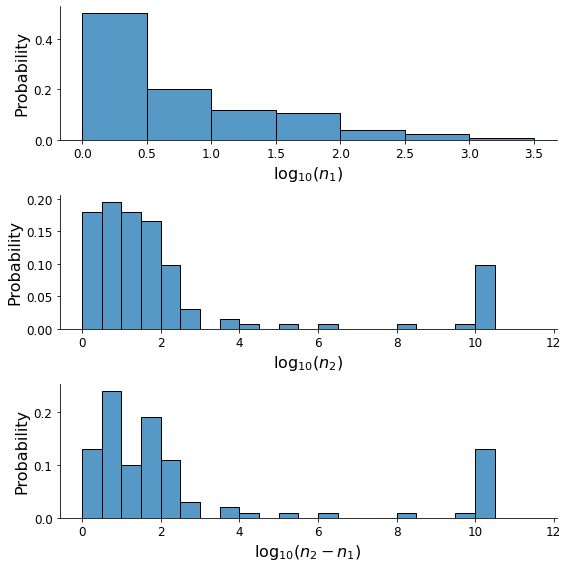

In [152]:
def fit_of_temp_params(df):
#     df = df.drop(columns=['delta_aicc'])
    df = select_group(df, 0)
    df = df.loc[df.drank == 0, :]
#     to_incude = df.step*df.scale > 0
#     print(np.sum(to_incude))
#     df = df.loc[to_incude, :]
    df = df.dropna(subset=['scale'])    
    df = df.rename(columns={'step': 'alpha'})

    df['n1'] = 1/df.loc[:, 'alpha']
    df['alphaC'] = df.loc[:, 'alpha'] * df.loc[:, 'scale']
    df.loc[df.alphaC.eq(0), 'alphaC'] = df.loc[df.alphaC != 0, 'alphaC'].min()
    df['n2'] = 1/df.alphaC
    df['logn1'] = np.log10(df.loc[:, 'n1'])
    df['logn2'] = np.log10(df.loc[:, 'n2'])
    df['ndiff'] = np.log10(df.n2 - df.n1)
    display(df.head())
    
    fig, ax = plt.subplots(nrows=3, figsize=[8, 8])
    sns.histplot(x=df.logn1, bins=np.arange(0, 4, .5), stat='probability', ax=ax[0])
    ax[0].set_xlabel(r'$\log_{10}(n_1)$')
    
    sns.histplot(x=df.logn2, bins=np.arange(0, 12, .5), stat='probability', ax=ax[1])
    ax[1].set_xlabel(r'$\log_{10}(n_2)$')
    
    sns.histplot(x=df.ndiff, bins=np.arange(0, 12, .5), stat='probability', ax=ax[2])
    ax[2].set_xlabel(r'$\log_{10}(n_2 - n_1)$')
    
    fig.tight_layout()
    fig.savefig('../figures/temp_params_transformed_unfiltered.pdf', dpi=300)
    
df = get_it_stats('../data/all_subsets_fits_app4.csv', 'aicc')
fit_of_temp_params(df)
del df

# Task selection (to be moved to another notebook)

0

activity,A1,A2,A3,A4
sid,,,,
0,0.000,0.064,0.712,0.224
1,0.296,0.116,0.388,0.200
2,0.472,0.132,0.000,0.396
3,0.180,0.076,0.336,0.408
4,0.504,0.016,0.320,0.160


Loadings:


,cPC1,cPC2,cPC3
activity,,,
A1,0.758109,-0.547926,-0.357804
A2,0.522310,0.783292,0.341499
A3,-0.410104,-0.451064,0.794564
A4,-0.843648,0.211838,-0.496345


Index(['index', 'sid', 'form', 'group', 'aicc', 'step', 'scale', 'mean', 'var',
       'delta_mean', 'delta_var', 'PC1', 'PC2', 'A1', 'A2', 'A3', 'A4', 'cPC1',
       'cPC2', 'cPC3', 'alloc_bias', 'final_rPC', 'delta_rPC', 'PC', 'A3vsA4',
       'step_', 'tdiff', 'tdiff_', 'cPC3_', 'norm', 'nmean', 'nvar',
       'ndelta_mean', 'ndelta_var'],
      dtype='object')

A1:
alloc_bias [∆AIC(L,Q)=110.58)]: 91.251, 0.000**
final_rPC [∆AIC(L,Q)=-1.73)]: 18.841, 0.000**
delta_rPC [∆AIC(L,Q)=-1.91)]: 8.024, 0.005**
PC [∆AIC(L,Q)=-1.36)]: 10.275, 0.002**
A2:
alloc_bias [∆AIC(L,Q)=82.89)]: 58.452, 0.000**
final_rPC [∆AIC(L,Q)=-1.73)]: 0.063, 0.802
delta_rPC [∆AIC(L,Q)=-1.71)]: 0.205, 0.651
PC [∆AIC(L,Q)=-2.00)]: 0.245, 0.621
A3:
alloc_bias [∆AIC(L,Q)=54.66)]: 40.978, 0.000**
final_rPC [∆AIC(L,Q)=-0.22)]: 3.193, 0.076
delta_rPC [∆AIC(L,Q)=-1.01)]: 0.945, 0.333
PC [∆AIC(L,Q)=-1.48)]: 1.518, 0.220
A4:
alloc_bias [∆AIC(L,Q)=84.32)]: 59.776, 0.000**
final_rPC [∆AIC(L,Q)=-2.00)]: 10.310, 0.002**
delta_rPC [∆AIC(L,Q)=-1.62)]: 4.175, 0.043*
PC [∆AIC(L,Q)=-1.08)]: 4.829, 0.030*


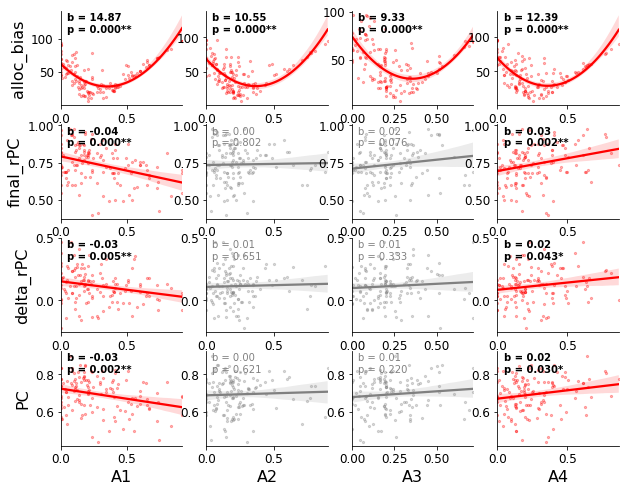

In [15]:
def allocPCandTempParams(data_path, behavior_data_path):
    bdf = pd.read_csv(behavior_data_path).set_index(['sid'])
    bdf = select_group(bdf, 0)
    bdf['prog'] = bdf.fpc15 - bdf.ipc15
    bdf_ = bdf.loc[bdf.activity!='A4', :]
    gbdf = bdf.groupby('sid')
    gbdf_ = bdf_.groupby('sid')
    display(bdf.maxscore.values.min())
    df = gbdf[['n']].apply(lambda x: np.std(x))

    weighted_mean = lambda x: np.sum(x.values.squeeze()*(np.array([1,2,3])/6))
    flat_mean = lambda x: np.mean(x.values.squeeze())

    func = weighted_mean

    df.columns = ['alloc_bias']
    df['final_rPC'] = gbdf_[['fpc15']].apply(func)
    df['delta_rPC'] = gbdf_[['fpc15']].apply(func) - gbdf_[['ipc15']].apply(func)
    df['PC'] = gbdf_[['pcall']].apply(func)
    ldf = df.copy()
    lvars = list(ldf.columns)
    del df
    
    df = pd.read_csv(behavior_data_path).filter(items=['sid','activity','alloc'])
    df = df.pivot(index='sid', columns='activity', values='alloc')
    display(df.head())
    
    # Create standardization object and do PCA on utility params
    scaler = StandardScaler()
    df_std = scaler.fit_transform(df)

    # Select components and loadings
    ncomps = 3
    pca = PCA(n_components=ncomps)
    pca.fit(df_std)
    scores = pca.transform(df_std)
    ccomps = ['cPC1', 'cPC2', 'cPC3']
    loadings = pd.DataFrame(pca.components_.T, columns=ccomps, index=df.columns)
    print('Loadings:')
    correlations = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), 
        columns = ccomps, 
        index = df.columns)
    display(correlations)
    
    # Add principal components to the DF
    df = pd.concat([df.reset_index(), pd.DataFrame(scores)], axis=1)
    df.columns.values[-ncomps:] = ccomps
    
    df = pd.read_csv(data_path).merge(df, on='sid')
    df = df.dropna(subset=['scale'])
    df = df.fillna(0)
    df = df.merge(ldf.reset_index(), on='sid')
    
    df['A3vsA4'] = df.A3 - df.A4
    df['step_'] = df.step**(1/3)
    df['tdiff'] = df.step*df.scale
    df['tdiff_'] = df.tdiff**(1/3)
    df['cPC3_'] = df.cPC3**(1/3)
    uparams = ['mean', 'var', 'delta_mean', 'delta_var']
    df['norm'] = np.sqrt((df.loc[:, uparams]**2).sum(axis=1))
    for up in uparams:
        df[f'n{up}'] = df.loc[:, up] / df.norm

    display(df.columns)
    rows = lvars
    cols = ['A1', 'A2', 'A3', 'A4']
    fig, ax = plt.subplots(ncols=len(cols), nrows=len(rows), num='temporal params', figsize=[2.5*len(cols), 2*len(rows)])
    for j, col in enumerate(cols):
        df[f'z{col}'] = stats.zscore(df.loc[:, col])
        print(f'{col.upper()}:')
        for i, row in enumerate(rows):
            reg = ols(f'{row} ~ z{col}', data=df).fit()
            qreg = ols(f'{row} ~ (z{col} + np.power(z{col}, 2))', data=df).fit()
            aic_diff = reg.aic - qreg.aic
            model = [reg, qreg][np.argmin([reg.aic, qreg.aic])]
            f, fpval = model.fvalue, model.f_pvalue
#             slope, intercept, r_value, p_value, std_err = stats.linregress(df.loc[:, col], df.loc[:, row])
            sign = '*' if fpval < .05 else ''
            sign = '**' if fpval < .01 else sign
            print(f'{row} [∆AIC(L,Q)={aic_diff:.2f})]: {f:.3f}, {fpval:.3f}{sign}')
            b2, pval = model.params.values[-1], model.pvalues.values[-1]
            report = f'b = {b2:.2f}\np = {pval:.3f}{sign}'
            ax[i, j].text(.05, .98, report, va='top', ha='left', 
                          transform=ax[i, j].transAxes, fontweight='bold' if sign else 'regular', 
                          color='black' if sign else 'gray')
            
            sns.regplot(y=row, x=col, data=df, ax=ax[i, j], color='red' if sign else 'gray', scatter_kws={'s':5, 'alpha':.3}, order=2 if aic_diff>2 else 1)
            if j:
                ax[i,j].set_ylabel('')
            if i<len(rows)-1:
                ax[i,j].set_xlabel('')
            else:
                ax[i,j].set_xlabel(f'{col}')
                
    
allocPCandTempParams('../data/pca_data_unstand.csv','../data/behavior_data.csv')